# Example for processing a WDM signal with one polarisation
Here will be step by step example of processing a WDM signal with one polarisation.
You need just to run all cells in order.
There will be additional comments what is going on in each cell.

## Importing libraries and setting up the environment

In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime
from importlib import reload

from prettytable import PrettyTable
from scipy.fft import fftshift, ifftshift, fft, ifft

import hpcom
from hpcom.signal import create_wdm_parameters, generate_wdm, get_points_wdm, receiver_wdm, nonlinear_shift, rrcosfilter
from hpcom.channel import create_channel_parameters
from hpcom.metrics import get_evm

# from ssfm_gpu.propagation import propagate_manakov, dispersion_compensation_manakov
from ssfm_gpu.propagation import propagate_schrodinger, dispersion_compensation
from ssfm_gpu.conversion import convert_forward, convert_inverse

import signal_handling.processing as prcs
import tools.functions as fn

import FNFTpy as fpy
import PJTpy as pjt

reload(prcs)
reload(hpcom)

from hpcom.signal import create_wdm_parameters, generate_wdm, get_points_wdm, receiver_wdm, nonlinear_shift, rrcosfilter

Allocate GPU memory

In [15]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

In [21]:
print(gpus)

[]


## Setting up the parameters of signal and channel

In [16]:
wdm = create_wdm_parameters(n_channels=1,
                            p_ave_dbm=3,
                            n_symbols=2 ** 16,
                            m_order=16,
                            roll_off=0.1,
                            upsampling=4,
                            downsampling_rate=1,
                            symb_freq=34e9,
                            channel_spacing=75e9,
                            n_polarisations=1,
                            seed='fixed')

channel = create_channel_parameters(n_spans=12,
                                    z_span=80,
                                    alpha_db=0.0,
                                    gamma=1.2,
                                    noise_figure_db=-200,  # -200 means there is no noise
                                    dispersion_parameter=16.8,
                                    dz=1)

name_set = fn.form_name(wdm, channel)
print(name_set)

_16qam_34gbd_12spans_80km


In [17]:
signal_x, wdm_info = generate_wdm(wdm)
points_x_orig = wdm_info['points_x'][0]
ft_filter_values = wdm_info['ft_filter_values_x'][0] / wdm['upsampling']  # [0] index for only one WDM channel

In [20]:
start_time = datetime.now()
signal_prop = propagate_schrodinger(channel, signal_x, sample_freq=int(wdm['symb_freq'] * wdm['upsampling']))
print("propagation took", (datetime.now() - start_time).total_seconds() * 1000, "ms")

propagation took 16424.073 ms


In [19]:
signal_cdc = dispersion_compensation(channel, signal_prop, 1. / wdm['sample_freq'])
points_x_cdc = get_points_wdm(hpcom.signal.filter_shaper(signal_cdc, ft_filter_values)[::wdm['downsampling_rate']], wdm) # downsample
shift_factor_x = np.dot(np.transpose(np.conjugate(points_x_orig)), points_x_orig) / np.dot(np.transpose(np.conjugate(points_x_orig)), points_x_cdc)
print(shift_factor_x, np.absolute(shift_factor_x))

(-0.14671987834945488+1.268369454025334j) 1.2768272375726495


In [8]:
process_parameters = prcs.get_default_process_parameters()
process_parameters['window_mode'] = 'cdc'
process_parameters['n_symb_proc'] = 16
process_parameters['n_symb_side'] = 256
process_parameters['n_symb_total'] = process_parameters['n_symb_proc'] + 2 * process_parameters['n_symb_side']
process_parameters['n_symb_skip'] = 1024
process_parameters['n_symb_add'] = fn.side_to_np2(process_parameters['n_symb_proc'] + 2 * process_parameters['n_symb_side'])  # add to total number of symbols to make it power of 2

In [9]:
# create array to store all recovered points
points_all = np.array([])
points_all_nft = np.array([])

## Signal windowing
<a id='signal_windowing'></a>

In [10]:
# cut the Tx and Rx signals to the size of the window
signal_windowed_cdc, t_window_cdc = prcs.get_windowed_signal(signal_prop, signal_parameters=wdm, process_parameters=process_parameters, channel=channel)
signal_tx_windowed_cdc, t_tx_window_cdc = prcs.get_windowed_signal(signal_x, signal_parameters=wdm, process_parameters=process_parameters, channel=channel)

## NFT processing

Convert signal to dimensionless form

In [11]:
convert_result = convert_inverse(signal_windowed_cdc, t_window_cdc, channel['z_span'],
                                 channel['beta2'],
                                 channel['gamma'],
                                 t0=1. / wdm['symb_freq'], type='nlse')

q_windowed_cdc = convert_result['q']
t_dl_window_cdc = convert_result['t']
dt_dl = t_dl_window_cdc[0] - t_dl_window_cdc[1]
z_span_dimless = convert_result['z']
z_dimless = z_span_dimless * channel['n_spans']

Arrange parameters for the transformation

In [12]:
t = (np.arange(len(signal_prop)) - len(signal_prop) / 2) / wdm['sample_freq']
n_t = len(t_dl_window_cdc)
t_span = t[-1] - t[0]

# shift time to shift signal in the center of the time interval
t_for_nft = t_dl_window_cdc - (t_dl_window_cdc[-1] + t_dl_window_cdc[0]) / 2

# arrange nonlinear frequency grid \xi
xi_upsampling = 4
n_xi = xi_upsampling * n_t
rv, xi_val = fpy.nsev_inverse_xi_wrapper(n_t, t_for_nft[0], t_for_nft[-1], n_xi)
xi = xi_val[0] + np.arange(n_xi) * (xi_val[1] - xi_val[0]) / (n_xi - 1)

Forward and inverse NFT

In [13]:
# Forward NFT
fnft_type=11

start_time = datetime.now()
result_nlse = fpy.nsev(q_windowed_cdc, t_for_nft, xi[0], xi[-1], n_xi, dst=2, cst=2, dis=fnft_type, K=2048, display_c_msg=True)
print("forward NFT took", (datetime.now() - start_time).total_seconds() * 1000, "ms")
start_time = datetime.now()
result_pjt = pjt.pjt(q_windowed_cdc, t_for_nft, contSpec=None, omp_num_threads=4, display_c_msg=True)
# result_pjt = pjt.pjt(q_windowed_cdc, t_for_nft, contSpec=np.concatenate([xi, result_nlse['cont_a']]), omp_num_threads=4, display_c_msg=True)
print("PJT took", (datetime.now() - start_time).total_seconds() * 1000, "ms")

# Nonlinear spectrum evolution
a = result_nlse['cont_a']
b = result_nlse['cont_b']
r = result_nlse['cont_ref']

res = result_pjt

rd = res['disc_res']
bd = res['disc_norm']
xi_d = res['bound_states']
# ad = bd / rd

b_prop = b * np.exp(-2. * 1.0j * z_dimless * np.power(xi, 2))
bd_prop = bd * np.exp(-2. * 1.0j * z_dimless * np.power(xi_d, 2))

# Inverse NFT
start_time = datetime.now()
result_nsev_inverse = fpy.nsev_inverse(xi, t_for_nft, b_prop, xi_d, bd_prop, cst=1, dst=0)
print("inverse NFT took", (datetime.now() - start_time).total_seconds() * 1000, "ms")
q_fnft = result_nsev_inverse['q']

FNFT Error: Division by zero.
 in nsev_compute_normconsts_or_residues(1035)-0.4.1
FNFT Error: Subroutine failure.
 in fnft_nsev_base(594)-0.4.1
FNFT Error: Subroutine failure.
 in fnft_nsev(342)-0.4.1
/home/esf0/anaconda3/envs/nn_env/lib/python3.9/site-packages/FNFTpy/auxiliary.py:159: UserWarning: An error occured when calling FNFT: error code -3
  warn(wstring)


forward NFT took 36830.02 ms
PJT took 211972.039 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 69423.39 ms


Inverse conversion from dimensionless form

In [14]:
convert_forward_result = convert_forward(q_fnft, t_dl_window_cdc, z_span_dimless,
                                         channel['beta2'],
                                         channel['gamma'],
                                         t0=1. / wdm['symb_freq'], type='nlse')

signal_nft = convert_forward_result['Q']
t_nft = convert_forward_result['T']

Decode constellation points

In [24]:
# add zeros to the end of the signal to process with the same length as the original signal
n_signal_total = len(signal_prop)
signal_nft_complete = np.concatenate([signal_nft, np.zeros(n_signal_total - len(signal_nft))])
signal_nft_complete = tf.cast(signal_nft_complete, tf.complex128)

points_x_nft = get_points_wdm(hpcom.signal.filter_shaper(signal_nft_complete, ft_filter_values)[::wdm['downsampling_rate']], wdm)

# for NFT processed we have n_symb_add + n_symb_side points from left
n_points_start_nft = int(process_parameters['n_symb_side'] + process_parameters['n_symb_add'])
n_points_end_nft = int(n_points_start_nft + process_parameters['n_symb_proc'])  # restore n_symb_proc points
range_points_nft = range(n_points_start_nft, n_points_end_nft)

# for original signal we have n_symb_skip + n_symb_side points from left
n_points_start_orig = int((process_parameters['n_symb_skip'] + process_parameters['n_symb_side']))
n_points_end_orig = int(n_points_start_orig + process_parameters['n_symb_proc'])  # restore n_symb_proc points
range_points_orig = range(n_points_start_orig, n_points_end_orig)

# points_found = scale_p * points_x_window[range_points]
points_found_nft = points_x_nft[range_points_nft]
points_was_orig = points_x_orig[range_points_orig]

# shift and rotate points, if needed
shift_factor_x_nft = np.dot(np.transpose(np.conjugate(points_was_orig)), points_was_orig) / np.dot(
    np.transpose(np.conjugate(points_was_orig)), points_found_nft)
points_found_nft *= shift_factor_x_nft
print("shift factor for x:", shift_factor_x_nft, np.absolute(shift_factor_x_nft))

shift factor for x: (-1.8461984408374148+2.037204871926234j) 2.749300342478152


In [19]:
table = PrettyTable()
for k in range(len(points_found_nft)):
    table.add_row(['{:.5f}'.format(points_was_orig[k]),
                   '{:.5f}'.format(points_found_nft[k])])

print(table)

+-------------------+-------------------+
|      Field 1      |      Field 2      |
+-------------------+-------------------+
| -0.04238-0.04238j | -0.04312-0.04233j |
|  0.04238-0.04238j |  0.04236-0.04120j |
|  0.01413-0.04238j |  0.01423-0.04439j |
| -0.04238+0.01413j | -0.04360+0.01601j |
| -0.04238-0.01413j | -0.04073-0.01620j |
| -0.01413+0.01413j | -0.01423+0.01467j |
| -0.04238-0.04238j | -0.04209-0.04362j |
|  0.04238+0.01413j |  0.04054+0.01441j |
| -0.01413-0.01413j | -0.01237-0.01435j |
| -0.01413-0.01413j | -0.01490-0.01407j |
| -0.04238+0.01413j | -0.04197+0.01410j |
| -0.04238+0.04238j | -0.04157+0.04332j |
| -0.01413+0.01413j | -0.01421+0.01380j |
| -0.01413-0.01413j | -0.01330-0.01431j |
|  0.01413+0.04238j |  0.01495+0.04014j |
| -0.01413+0.01413j | -0.01449+0.01652j |
+-------------------+-------------------+


Now we can store points and continue signal processing

In [16]:
points_all = np.concatenate([points_all, points_was_orig])
points_all_nft = np.concatenate([points_all_nft, points_found_nft])

Now we can increment 'n_symb_skip' by 'n_symb_proc' and continue signal processing

In [17]:
process_parameters['n_symb_skip'] += process_parameters['n_symb_proc']

Go to [Signal windowing](#signal_windowing) section

# Here is the same example but with single function

In [15]:
def example_nlse_processing(wdm, channel, process_parameters, job_name='test', dir='', display_c_msg=True, omp_num_threads=4, n_iter_save=1):

    # display_c_msg = False
    # omp_num_threads = 4
    xi_upsampling = 4

    # n_iter_save = 10  # Number of iterations after which to save to a parquet file

    # Initialize DataFrame to hold the variables to save after every N iterations
    intermediate_results = pd.DataFrame()

    signal_x, wdm_info = generate_wdm(wdm)
    points_x_orig = wdm_info['points_x'][0]
    ft_filter_values = wdm_info['ft_filter_values_x'][0] / wdm['upsampling']  # [0] index for only one WDM channel

    start_time = datetime.now()
    signal_prop = propagate_schrodinger(channel, signal_x, sample_freq=int(wdm['symb_freq'] * wdm['upsampling']))
    print("propagation took", (datetime.now() - start_time).total_seconds() * 1000, "ms")

    signal_cdc = dispersion_compensation(channel, signal_prop, 1. / wdm['sample_freq'])
    points_x_cdc = get_points_wdm(hpcom.signal.filter_shaper(signal_cdc, ft_filter_values)[::wdm['downsampling_rate']],
                                  wdm)  # downsample
    shift_factor_x = np.dot(np.transpose(np.conjugate(points_x_orig)), points_x_orig) / np.dot(
        np.transpose(np.conjugate(points_x_orig)), points_x_cdc)
    print(shift_factor_x, np.absolute(shift_factor_x))


    # create array to store all recovered points
    points = np.array([])
    points_nft = np.array([])
    evm = np.array([])
    return_values = np.empty((0,3), int)

    for _ in range(process_parameters['n_steps']):
        print("Processing iteration", _, "of", process_parameters['n_steps'])  # print step number

        # Signal windowing
        # ----------------
        # cut the Tx and Rx signals to the size of the window
        signal_windowed_cdc, t_window_cdc = prcs.get_windowed_signal(signal_prop, signal_parameters=wdm, process_parameters=process_parameters, channel=channel)
        signal_tx_windowed_cdc, t_tx_window_cdc = prcs.get_windowed_signal(signal_x, signal_parameters=wdm, process_parameters=process_parameters, channel=channel)


        # Convert signal to dimensionless form
        # ------------------------------------
        convert_result = convert_inverse(signal_windowed_cdc, t_window_cdc, channel['z_span'],
                                     channel['beta2'],
                                     channel['gamma'],
                                     t0=1. / wdm['symb_freq'], type='nlse')

        q_windowed_cdc = convert_result['q']
        t_dl_window_cdc = convert_result['t']
        dt_dl = t_dl_window_cdc[0] - t_dl_window_cdc[1]
        z_span_dimless = convert_result['z']
        z_dimless = z_span_dimless * channel['n_spans']


        # Arrange parameters for the transformation
        # -----------------------------------------
        t = (np.arange(len(signal_prop)) - len(signal_prop) / 2) / wdm['sample_freq']
        n_t = len(t_dl_window_cdc)
        t_span = t[-1] - t[0]

        # shift time to shift signal in the center of the time interval
        t_for_nft = t_dl_window_cdc - (t_dl_window_cdc[-1] + t_dl_window_cdc[0]) / 2

        # arrange nonlinear frequency grid \xi
        # xi_upsampling = 4
        n_xi = xi_upsampling * n_t
        rv, xi_val = fpy.nsev_inverse_xi_wrapper(n_t, t_for_nft[0], t_for_nft[-1], n_xi)
        xi = xi_val[0] + np.arange(n_xi) * (xi_val[1] - xi_val[0]) / (n_xi - 1)


        # Forward NFT
        # -----------
        fnft_type=11

        start_time = datetime.now()
        result_nlse = fpy.nsev(q_windowed_cdc, t_for_nft, xi[0], xi[-1], n_xi, dst=3, cst=2, dis=fnft_type, K=2048, display_c_msg=display_c_msg)
        print("forward NFT took", (datetime.now() - start_time).total_seconds() * 1000, "ms")
        start_time = datetime.now()
        result_pjt = pjt.pjt(q_windowed_cdc, t_for_nft,
                             contSpec=None, omp_num_threads=omp_num_threads, display_c_msg=display_c_msg)
        # result_pjt = pjt.pjt(q_windowed_cdc, t_for_nft, contSpec=np.concatenate([xi, result_nlse['cont_a']]), omp_num_threads=4, display_c_msg=True)
        print("PJT took", (datetime.now() - start_time).total_seconds() * 1000, "ms")


        # Nonlinear spectrum evolution
        # ----------------------------
        a = result_nlse['cont_a']
        b = result_nlse['cont_b']
        r = result_nlse['cont_ref']

        res = result_pjt

        rd = res['disc_res']
        bd = res['disc_norm']
        xi_d = res['bound_states']
        # ad = bd / rd


        b_prop = b * np.exp(-2. * 1.0j * z_dimless * np.power(xi, 2))
        bd_prop = bd * np.exp(-2. * 1.0j * z_dimless * np.power(xi_d, 2))


        # Inverse NFT
        # -----------
        start_time = datetime.now()
        result_nsev_inverse = fpy.nsev_inverse(xi, t_for_nft, b_prop, xi_d, bd_prop,
                                               cst=1, dst=0, display_c_msg=display_c_msg)
        print("inverse NFT took", (datetime.now() - start_time).total_seconds() * 1000, "ms")
        q_fnft = result_nsev_inverse['q']

        # print("RETURN VALUES FROM FNFT / PJT / IFNFT",
        #       result_nlse['return_value'],
        #       res['return_value'],
        #       result_nsev_inverse['return_value'])

        # Inverse conversion from dimensionless form
        # ------------------------------------------
        convert_forward_result = convert_forward(q_fnft, t_dl_window_cdc, z_span_dimless,
                                             channel['beta2'],
                                             channel['gamma'],
                                             t0=1. / wdm['symb_freq'], type='nlse')

        signal_nft = convert_forward_result['Q']
        t_nft = convert_forward_result['T']


        # Decode constellation points
        # ---------------------------
        # add zeros to the end of the signal to process with the same length as the original signal
        n_signal_total = len(signal_prop)
        signal_nft_complete = np.concatenate([signal_nft, np.zeros(n_signal_total - len(signal_nft))])
        signal_nft_complete = tf.cast(signal_nft_complete, tf.complex128)

        points_x_nft = get_points_wdm(hpcom.signal.filter_shaper(signal_nft_complete, ft_filter_values)[::wdm['downsampling_rate']], wdm)

        # for NFT processed we have n_symb_add + n_symb_side points from left
        n_points_start_nft = int(process_parameters['n_symb_side'] + process_parameters['n_symb_add'])
        n_points_end_nft = int(n_points_start_nft + process_parameters['n_symb_proc'])  # restore n_symb_proc points
        range_points_nft = range(n_points_start_nft, n_points_end_nft)

        # for original signal we have n_symb_skip + n_symb_side points from left
        n_points_start_orig = int((process_parameters['n_symb_skip'] + process_parameters['n_symb_side']))
        n_points_end_orig = int(n_points_start_orig + process_parameters['n_symb_proc'])  # restore n_symb_proc points
        range_points_orig = range(n_points_start_orig, n_points_end_orig)

        # points_found = scale_p * points_x_window[range_points]
        points_found_nft = points_x_nft[range_points_nft]
        points_was_orig = points_x_orig[range_points_orig]

        # shift and rotate points, if needed
        shift_factor_x_nft = np.dot(np.transpose(np.conjugate(points_was_orig)), points_was_orig) / np.dot(
            np.transpose(np.conjugate(points_was_orig)), points_found_nft)
        points_found_nft *= shift_factor_x_nft
        print("shift factor for x:", shift_factor_x_nft)


        # Now we can store points and continue signal processing
        # ------------------------------------------------------
        points = np.concatenate([points, points_was_orig])
        points_nft = np.concatenate([points_nft, points_found_nft])
        evm = np.append(evm, get_evm(points_was_orig, points_found_nft))
        return_values = np.append(return_values, [[result_nlse['return_value'], res['return_value'], result_nsev_inverse['return_value']]])

        # Now we can increment 'n_symb_skip' by 'n_symb_proc' and continue signal processing
        process_parameters['n_symb_skip'] += process_parameters['n_symb_proc']


        # Create a dictionary with current values of b, r, rd, bd, xi_d, xi, q_windowed_cdc, and t_for_nft
        iteration_data = {
            'b': [b],
            'r': [r],
            'rd': [rd],
            'bd': [bd],
            'xi_d': [xi_d],
            'xi': [xi],
            'q_windowed_cdc': [q_windowed_cdc],
            't_for_nft': [t_for_nft]
        }

        # Append the dictionary as a new row to the DataFrame
        # intermediate_results = intermediate_results.append(iteration_data, ignore_index=True)
        intermediate_results = pd.concat([intermediate_results, pd.DataFrame(iteration_data)], ignore_index=True)

        # If the current iteration number is divisible by N, save the DataFrame to a parquet file
        if (_ % n_iter_save == 0) or (_ == process_parameters['n_steps'] - 1):
            # intermediate_results.to_parquet(f'results_processing' + job_name + '.parquet')
            intermediate_results.to_pickle(dir + 'results_processing_' + job_name + '.pkl')



    result = {
        'points': points,
        'points_nft': points_nft,
        'evm': evm,
        'return_values': return_values
    }

    # Store the variables in a dictionary
    results_to_save = {
        'signal_x': [signal_x.numpy()],
        'wdm_info': [wdm_info],
        'signal_prop': [signal_prop.numpy()],
        'signal_cdc': [signal_cdc.numpy()],
        'points_x_cdc': [points_x_cdc],
        'points_x_orig': [points_x_orig],
        'process_parameters': [process_parameters],
        'wdm': [wdm],
        'channel': [channel],
        'points': [points],
        'points_nft': [points_nft],
        'evm': [evm],
        'return_values': [return_values]
    }

    # Convert the dictionary to a pandas DataFrame
    df = pd.DataFrame(results_to_save)

    # Save the DataFrame to a parquet file
    # df.to_parquet('results_meta_' + job_name + '.parquet')
    df.to_pickle(dir + 'results_meta_' + job_name + '.pkl')

    return result

In [16]:
process_parameters = prcs.get_default_process_parameters()
process_parameters['window_mode'] = 'cdc'
# process_parameters['n_steps'] = 256
process_parameters['n_steps'] = 3
process_parameters['n_symb_proc'] = 32
process_parameters['n_symb_side'] = 300
process_parameters['n_symb_total'] = process_parameters['n_symb_proc'] + 2 * process_parameters['n_symb_side']
# process_parameters['n_symb_skip'] = 1024
process_parameters['n_symb_skip'] = 1224
process_parameters['n_symb_add'] = fn.side_to_np2(process_parameters['n_symb_proc'] + 2 * process_parameters['n_symb_side'])  # add to total number of symbols to make it power of 2

result = example_nlse_processing(wdm, channel, process_parameters, job_name='test', dir='data/')
points = result['points']
points_nft = result['points_nft']
evms = result['evm']

propagation took 1133.722 ms
(-0.14671987457290264+1.268369454074717j) 1.2768272371877427
Processing iteration 0 of 3
forward NFT took 34.961 ms
PJT took 8618.349 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1900.0649999999998 ms
shift factor for x: (1.0014332254400962+0.010203908149376158j)
Processing iteration 1 of 3


/tmp/ipykernel_7266/765015361.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  intermediate_results = intermediate_results.append(iteration_data, ignore_index=True)


forward NFT took 34.816 ms
PJT took 10674.377 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1966.221 ms
shift factor for x: (1.0037517904813373+0.0009218111640414312j)
Processing iteration 2 of 3


/tmp/ipykernel_7266/765015361.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  intermediate_results = intermediate_results.append(iteration_data, ignore_index=True)


forward NFT took 34.879 ms
PJT took 10079.033000000001 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1990.477 ms
shift factor for x: (0.9996064651406541+0.0009289119589409591j)


/tmp/ipykernel_7266/765015361.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  intermediate_results = intermediate_results.append(iteration_data, ignore_index=True)


In [135]:
def get_evm_outlier_indices(evms, n_std_dev=2.5):

    mean = np.mean(evms)
    std_dev = np.std(evms)

    # Any point more than 3 standard deviations away from the mean will be considered an outlier
    # outlier_indices = np.where(np.abs(evms - mean) > 3*std_dev)  # both sides
    outlier_indices = np.where((evms - mean) > n_std_dev*std_dev)  # only right side (significantly bigger)
    ok_indices = np.where((evms - mean) <= n_std_dev*std_dev)  # only right side (significantly bigger)

    return outlier_indices, ok_indices

def delete_outliners(points, evms, n_symb_proc, n_std_dev=2.5):

    points_shaped = points.reshape((-1, n_symb_proc))  # slice with initial n_symb_proc
    outlier_indices, ok_indices = get_evm_outlier_indices(evms, n_std_dev=n_std_dev)  # find indices to left
    return points_shaped[ok_indices].reshape(-1)  # reshape back

In [136]:
points_nft_good = delete_outliners(points_nft, evms, process_parameters['n_symb_proc'], n_std_dev=2.5)

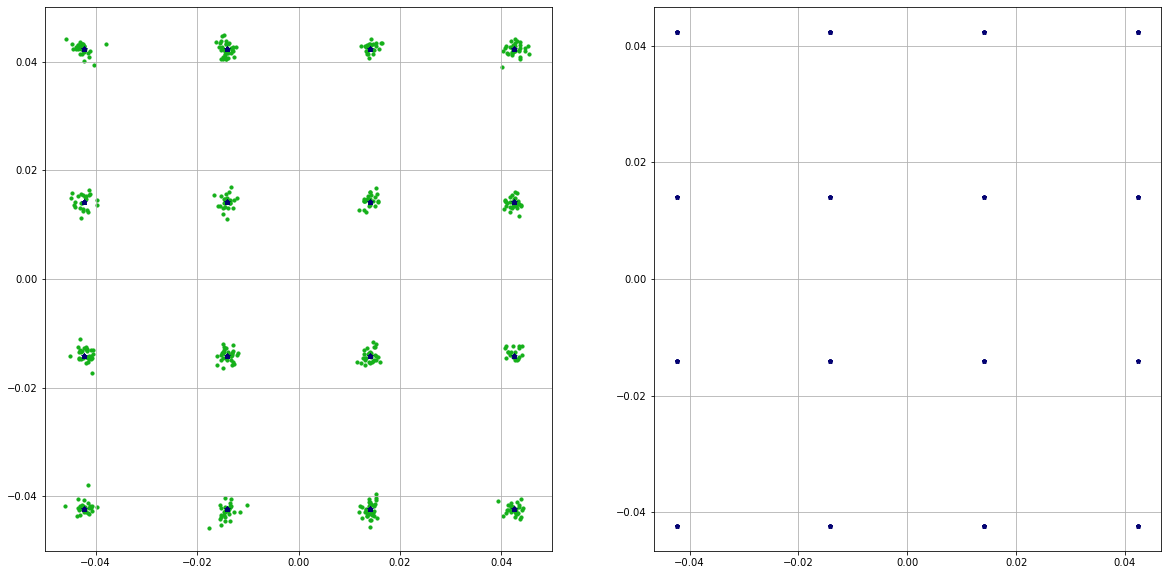

In [137]:
pk = 3
plot_range = range(pk * process_parameters['n_symb_proc'], (pk + 1) * process_parameters['n_symb_proc'])

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
# axs[0].scatter(points_nft.real, points_nft.imag, s=10, c='xkcd:green', marker='o')
axs[0].scatter(points_nft_good.real, points_nft_good.imag, s=10, c='xkcd:green', marker='o')
# axs[0].scatter(points_nft[plot_range].real, points_nft[plot_range].imag, s=20, c='xkcd:red', marker='o')
# axs[0].scatter(points_nft_slice[outlier_indices].real, points_nft_slice[outlier_indices].imag, s=20, c='xkcd:red', marker='o')
axs[0].scatter(points.real, points.imag, s=20, c='xkcd:deep blue', marker='*')
axs[0].grid(True)
axs[0].set_xlim([-0.05, 0.05])
axs[0].set_ylim([-0.05, 0.05])

axs[1].scatter(points.real, points.imag, s=15, c='xkcd:deep blue', marker='*')
axs[1].grid(True)

In [56]:
process_parameters = prcs.get_default_process_parameters()
process_parameters['window_mode'] = 'cdc'
# process_parameters['n_steps'] = 256
process_parameters['n_steps'] = 2
process_parameters['n_symb_proc'] = 32
process_parameters['n_symb_side'] = 300
process_parameters['n_symb_total'] = process_parameters['n_symb_proc'] + 2 * process_parameters['n_symb_side']
# process_parameters['n_symb_skip'] = 1024
process_parameters['n_symb_skip'] = 1227
process_parameters['n_symb_add'] = fn.side_to_np2(process_parameters['n_symb_proc'] + 2 * process_parameters['n_symb_side'])  # add to total number of symbols to make it power of 2

res_failed = example_nlse_processing(wdm, channel, process_parameters)
points_failed = res_failed['points']
points_nft_failed = res_failed['points_nft']
evms_failed = res_failed['evm']

propagation took 1101.1850000000002 ms
(-0.14671987457290264+1.268369454074717j) 1.2768272371877427
Processing iteration 0 of 2
forward NFT took 5197.6269999999995 ms
PJT took 9694.331999999999 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1927.183 ms
RETURN VALUES FROM FNFT / PJT / IFNFT 0 0 0
shift factor for x: (0.998481248184577+0.003307373750092116j)
Processing iteration 1 of 2
forward NFT took 5175.309 ms
PJT took 11414.99 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 2089.377 ms
RETURN VALUES FROM FNFT / PJT / IFNFT 0 0 0
shift factor for x: (1.0033654868206-0.010169065342784892j)


ValueError: too many values to unpack (expected 2)

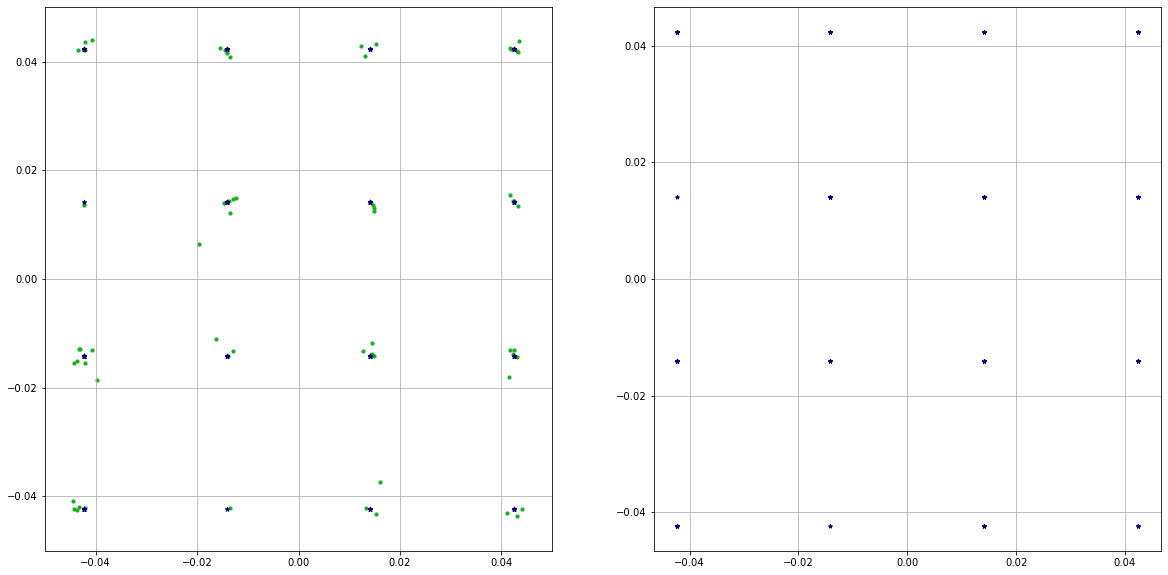

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].scatter(points_nft_failed.real, points_nft_failed.imag, s=10, c='xkcd:green', marker='o')
axs[0].scatter(points_failed.real, points_failed.imag, s=20, c='xkcd:deep blue', marker='*')
axs[0].grid(True)
axs[0].set_xlim([-0.05, 0.05])
axs[0].set_ylim([-0.05, 0.05])

axs[1].scatter(points_failed.real, points_failed.imag, s=15, c='xkcd:deep blue', marker='*')
axs[1].grid(True)